In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Sentiment Analysis on Covid-19 tweets

### Load Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import re

### Load and preprocess data

In [31]:
def load_and_preprocess_data(filepath):
  df= pd.read_csv(filepath)
  x= list(map(str,df.OriginalTweet))
  y= list(map(str, df.Sentiment))
  s_to_n= {'Negative':0, 'Positive': 1, 'Neutral': 2}
  n_to_s= {0:'Negative', 1:'Positive', 2:'Neutral'}
  for i in range(len(y)):
    y[i]=re.sub('Extremely Negative', 'Negative', y[i])
    y[i]=re.sub('Extremely Positive', 'Positive', y[i])
    y[i]= s_to_n[y[i]]
  for i in range(len(x)):
    x[i]= re.sub('https:\S+', '', x[i]).lower()
    x[i]= re.sub('\s+',' ', x[i])
    x[i]=re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+', '', x[i])
  y= tf.keras.utils.to_categorical(y, num_classes=3)
  ds= tf.data.Dataset.from_tensor_slices((x, y))
  ds= ds.shuffle(10000).batch(64).prefetch(tf.data.AUTOTUNE)
  return ds, n_to_s

In [32]:
def encode_data(train_ds):
  VOCAB_SIZE = 10000
  encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, output_mode='int', output_sequence_length=200)
  encoder.adapt(train_ds.map(lambda text, label: text))
  return encoder

In [33]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Compile model

In [41]:
def Sentiment_model(encoder):
  model = tf.keras.Sequential([
      encoder,
      layers.Embedding(10000, 64, mask_zero=True),
      layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
      layers.GlobalMaxPool1D(),
      layers.Dropout(0.4),
      layers.Dense(64, activation='relu'),
      layers.Dropout(0.4),
      layers.Dense(3, activation='softmax'),])
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])
  return model

### Fit model

In [42]:
train_filepath= "/content/drive/MyDrive/Corona_Sentiment/Corona_NLP_train.csv"
test_filepath= "/content/drive/MyDrive/Corona_Sentiment/Corona_NLP_test.csv"
train_ds, n_to_s=load_and_preprocess_data(train_filepath)
test_ds, _= load_and_preprocess_data(test_filepath)
encoder= encode_data(train_ds)
my_model= Sentiment_model(encoder)

In [43]:
history = my_model.fit(train_ds, epochs=3,
                    validation_data=test_ds,
                    validation_steps=30)

Epoch 1/3
644/644 [==============================] - 67s 89ms/step - loss: 0.9868 - accuracy: 0.4610 - val_loss: 0.9130 - val_accuracy: 0.5630
Epoch 2/3
644/644 [==============================] - 54s 85ms/step - loss: 0.7360 - accuracy: 0.7050 - val_loss: 0.6695 - val_accuracy: 0.7365
Epoch 3/3
644/644 [==============================] - 55s 86ms/step - loss: 0.5141 - accuracy: 0.8228 - val_loss: 0.6082 - val_accuracy: 0.7734


In [44]:
history = my_model.fit(train_ds, epochs=3,
                    validation_data=test_ds,
                    validation_steps=30)

Epoch 1/3
644/644 [==============================] - 56s 87ms/step - loss: 0.4080 - accuracy: 0.8706 - val_loss: 0.5831 - val_accuracy: 0.8010
Epoch 2/3
644/644 [==============================] - 56s 86ms/step - loss: 0.3473 - accuracy: 0.8930 - val_loss: 0.5077 - val_accuracy: 0.8229
Epoch 3/3
644/644 [==============================] - 53s 83ms/step - loss: 0.3072 - accuracy: 0.9078 - val_loss: 0.4973 - val_accuracy: 0.8276


### Evaluate model

In [45]:
test_loss, test_acc = my_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

60/60 [==============================] - 1s 22ms/step - loss: 0.5336 - accuracy: 0.8175
Test Loss: 0.5335776209831238
Test Accuracy: 0.8175355195999146


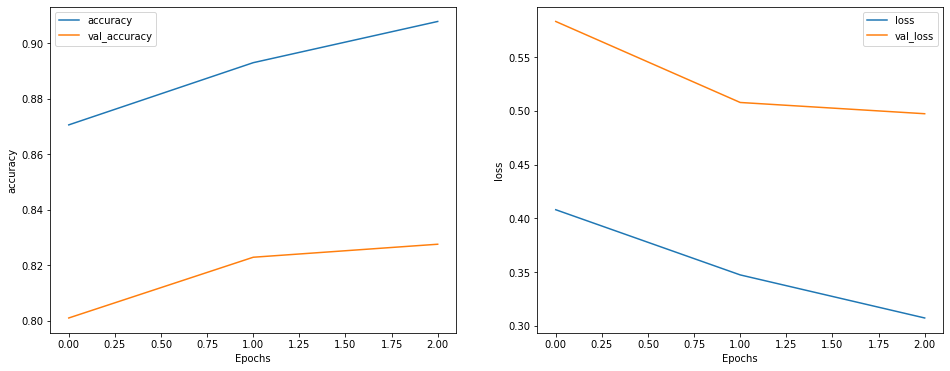

In [46]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')